In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
dir_of_interest ="G:/Project_BrainClassification/"
os.chdir(dir_of_interest)

In [3]:
X_test = np.load('X_test.npy')
X_train=np.load('X_train.npy')
Y_test=np.load('y_test.npy')
Y_train=np.load('y_train.npy')

In [20]:
from skimage.transform import resize

In [4]:
X_test.shape

(56, 240, 960)

In [18]:
image = X_test[0]

In [21]:
image = resize(image, (224, 224))

In [22]:
image.shape

(224, 224)

In [23]:
arru = []
arru.append(image)

In [24]:
arru = np.array(arru)

In [25]:
arru.shape

(1, 224, 224)

In [26]:
arru = np.repeat(arru[..., np.newaxis], 3, -1)

In [27]:
arru.shape

(1, 224, 224, 3)

In [13]:
from skimage.transform import resize

Text(0.5, 1.0, 'G type tumor')

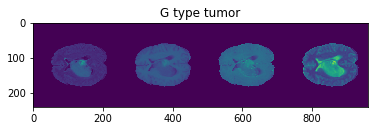

In [14]:
plt.imshow(X_train[0])
plt.title(Y_train[0]+" type tumor")

Text(0.5, 1.0, 'A type tumor')

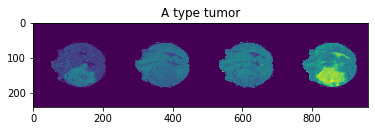

In [15]:
plt.imshow(X_train[3])
plt.title(Y_train[3]+" type tumor")

Text(0.5, 1.0, 'O type tumor')

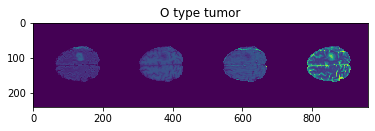

In [16]:
plt.imshow(X_train[12])
plt.title(Y_train[12]+" type tumor")

In [17]:
X_newTest=[]
for img in range(len(X_test)):
    result = resize(X_test[img,:,:], (224, 224))
    X_newTest.append(result)

In [18]:
X_newTrain=[]
for img in range(len(X_train)):
    result = resize(X_train[img,:,:], (224, 224))  #Initially 100,400 but resnet50 accepts 224,244
    X_newTrain.append(result)

In [19]:
X_newTest=np.array(X_newTest)
X_newTest.shape

(56, 224, 224)

In [20]:
X_newTrain=np.array(X_newTrain)
X_newTrain.shape

(165, 224, 224)

In [21]:
Y_test[Y_test=='G']=0
Y_test[Y_test=='A']=1
Y_test[Y_test=='O']=2

Y_train[Y_train=='G']=0
Y_train[Y_train=='A']=1
Y_train[Y_train=='O']=2

Y_test=Y_test.astype(int)
Y_train=Y_train.astype(int)

In [22]:
# Number of G's in the training dataset
num_A_train = sum(Y_train==0)
# Number of A's in the training dataset
num_B_train = sum(Y_train==1)
# Number of O's in the training dataset
num_C_train = sum(Y_train==2)

# Number of G's in the test dataset
num_A_test = sum(Y_test==0)
# Number of A's in the test dataset
num_B_test = sum(Y_test==1)
# Number of O's in the test dataset
num_C_test = sum(Y_test==2)

# Print statistics about the dataset
print("Training set:")
print("\tG: {}, A: {}, O: {}".format(num_A_train, num_B_train, num_C_train))
print("Test set:")
print("\tG: {}, A: {}, O: {}".format(num_A_test, num_B_test, num_C_test))

Training set:
	G: 101, A: 40, O: 24
Test set:
	G: 32, A: 14, O: 10


In [23]:
XTrain_rgb_batch = np.repeat(X_newTrain[..., np.newaxis], 3, -1)
print(XTrain_rgb_batch.shape)

(165, 224, 224, 3)


In [24]:
XTest_rgb_batch = np.repeat(X_newTest[..., np.newaxis], 3, -1)
print(XTest_rgb_batch.shape)  # (64, 224, 224, 3)

(56, 224, 224, 3)


In [25]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [26]:
y_train_OH = to_categorical(Y_train,3)
y_train_OH.shape

(165, 3)

In [27]:
y_test_OH = to_categorical(Y_test,3)
y_test_OH.shape

(56, 3)

In [28]:
# Normalize image vectors
XTrain_rgb_batch=XTrain_rgb_batch/255
XTest_rgb_batch=XTest_rgb_batch/255

print ("number of training examples = " + str(XTrain_rgb_batch.shape[0]))
print ("number of test examples = " + str(XTest_rgb_batch.shape[0]))
print ("X_train shape: " + str(XTrain_rgb_batch.shape))
print ("Y_train shape: " + str(y_train_OH.shape))
print ("X_test shape: " + str(XTest_rgb_batch.shape))
print ("Y_test shape: " + str(y_test_OH.shape))

number of training examples = 165
number of test examples = 56
X_train shape: (165, 224, 224, 3)
Y_train shape: (165, 3)
X_test shape: (56, 224, 224, 3)
Y_test shape: (56, 3)


In [29]:
from keras import applications

In [30]:
base_model = applications.resnet50.ResNet50(weights= 'imagenet', include_top=False, input_shape= (224,224,3))

F:\Anaconda\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [31]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.models import Sequential,Model,load_model

In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(3, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

Instead of giving equal weighting to all training examples, focal loss down-weights the well-classified examples.

In [33]:
from keras import backend as K
import tensorflow as tf
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [34]:
from keras.optimizers import SGD, Adam

adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss=[focal_loss(alpha=.25, gamma=2)], metrics=['accuracy'])

In [35]:
from keras.callbacks import EarlyStopping

In [36]:
early_stopping_monitor = EarlyStopping(patience=2)

Model is highly biased toward 'G' class, so we assign weights to class as other class are equally important as G

In [37]:
class_weight = {0:0.1,1:30,2:50}

In [38]:
model.fit(XTrain_rgb_batch, y_train_OH, epochs = 10, batch_size = 16,validation_split=0.3,callbacks = [early_stopping_monitor])

Train on 115 samples, validate on 50 samples
Epoch 1/10
115/115 [==============================] - 633s 6s/step - loss: 0.1903 - accuracy: 0.3652 - val_loss: 0.0687 - val_accuracy: 0.6400
Epoch 2/10
115/115 [==============================] - 256s 2s/step - loss: 0.1151 - accuracy: 0.5913 - val_loss: 0.0653 - val_accuracy: 0.4200
Epoch 3/10
115/115 [==============================] - 167s 1s/step - loss: 0.1181 - accuracy: 0.6087 - val_loss: 0.0785 - val_accuracy: 0.2200
Epoch 4/10
115/115 [==============================] - 154s 1s/step - loss: 0.0613 - accuracy: 0.7565 - val_loss: 0.0875 - val_accuracy: 0.2200


In [39]:
preds = model.evaluate(XTest_rgb_batch, y_test_OH)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

56/56 [==============================] - 24s 430ms/step
Loss = 0.08531935832330159
Test Accuracy = 0.25


In [40]:
y_pred = model.predict(XTest_rgb_batch)

In [41]:
from sklearn.metrics import confusion_matrix
from numpy import argmax

normal_ypred = argmax(y_pred,axis=1)
normal_ytest = argmax(y_test_OH,axis=1)


normal_ypred=normal_ypred.astype(str)
normal_ytest=normal_ytest.astype(str)

normal_ypred[normal_ypred=='0']='G'
normal_ypred[normal_ypred=='1']='A'
normal_ypred[normal_ypred=='2']='O'

normal_ytest[normal_ytest=='0']='G'
normal_ytest[normal_ytest=='1']='A'
normal_ytest[normal_ytest=='2']='O'
confusion_matrix(normal_ytest, normal_ypred,labels=['G','A','O'])

array([[ 0, 30,  2],
       [ 0, 14,  0],
       [ 2,  8,  0]], dtype=int64)

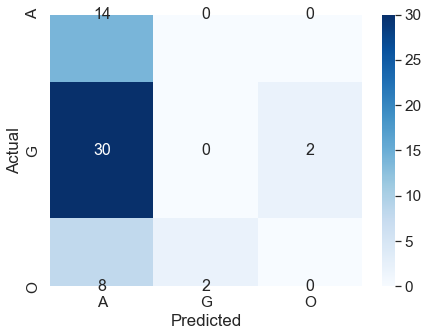

In [42]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

data = confusion_matrix(normal_ytest, normal_ypred)
df_cm = pd.DataFrame(data, columns=np.unique(normal_ytest), index = np.unique(normal_ytest))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (7,5))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [43]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

res3a_branch2c (Conv2D)         (None, 28, 28, 512)  66048       activation_12[0][0]              
__________________________________________________________________________________________________
res3a_branch1 (Conv2D)          (None, 28, 28, 512)  131584      activation_10[0][0]              
__________________________________________________________________________________________________
bn3a_branch2c (BatchNormalizati (None, 28, 28, 512)  2048        res3a_branch2c[0][0]             
__________________________________________________________________________________________________
bn3a_branch1 (BatchNormalizatio (None, 28, 28, 512)  2048        res3a_branch1[0][0]              
__________________________________________________________________________________________________
add_4 (Add)                     (None, 28, 28, 512)  0           bn3a_branch2c[0][0]              
                                                                 bn3a_branch1[0][0]               
__________

__________________________________________________________________________________________________


Save your model

In [44]:
model_json = model.to_json()
with open("model_arch.json", "w") as json_file:
    json_file.write(model_json)

In [45]:
model.save_weights("my_model_weights.h5")

In [46]:
from keras.models import model_from_json
with open("model_arch.json", 'r') as f:
    new_model_1 = model_from_json(f.read())

In [47]:
new_model_1.load_weights('my_model_weights.h5')

In [48]:
XTest_rgb_batch.shape

(56, 224, 224, 3)

single image

In [49]:
image = [XTest_rgb_batch[0]]
image=np.array(image)

In [50]:
image.shape

(1, 224, 224, 3)

In [51]:
pred2= new_model_1.predict(image)

In [52]:
pred2=argmax(pred2,axis=1)
pred2=pred2.astype(str)

pred2[pred2=='0']='G'
pred2[pred2=='1']='A'
pred2[pred2=='2']='O'

Multiple images

In [64]:
pred3 = new_model_1.predict(XTest_rgb_batch)

In [65]:
pred3

array([[0.24111275, 0.48168597, 0.27720124],
       [0.29317355, 0.40573558, 0.3010909 ],
       [0.28038272, 0.41369516, 0.30592218],
       [0.2772621 , 0.43782076, 0.28491718],
       [0.25550506, 0.4542065 , 0.29028848],
       [0.24288781, 0.51988655, 0.23722559],
       [0.18013623, 0.46962878, 0.35023493],
       [0.19492362, 0.4455733 , 0.35950312],
       [0.29227424, 0.45349157, 0.2542341 ],
       [0.32614386, 0.39872652, 0.2751297 ],
       [0.30774683, 0.4179185 , 0.2743347 ],
       [0.2729197 , 0.46017408, 0.26690626],
       [0.30470306, 0.4014357 , 0.29386133],
       [0.2627348 , 0.4290679 , 0.3081973 ],
       [0.17797856, 0.57508403, 0.24693741],
       [0.27617058, 0.41668153, 0.30714792],
       [0.27376878, 0.42568427, 0.30054694],
       [0.2117248 , 0.46354994, 0.32472524],
       [0.25852868, 0.46393827, 0.27753296],
       [0.2603132 , 0.45293006, 0.28675672],
       [0.19380265, 0.52028674, 0.28591058],
       [0.2665706 , 0.48109192, 0.25233755],
       [0.

In [66]:
pred3 = argmax(pred3,axis=1)
normal_ytest = argmax(y_test_OH,axis=1)


pred3=pred3.astype(str)
normal_ytest=normal_ytest.astype(str)

pred3[pred3=='0']='G'
pred3[pred3=='1']='A'
pred3[pred3=='2']='O'

normal_ytest[normal_ytest=='0']='G'
normal_ytest[normal_ytest=='1']='A'
normal_ytest[normal_ytest=='2']='O'
confusion_matrix(normal_ytest, pred3,labels=['G','A','O'])

array([[ 0, 30,  2],
       [ 0, 14,  0],
       [ 2,  8,  0]], dtype=int64)

In [67]:
pred3

array(['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',
       'A', 'A', 'A', 'A', 'A', 'G', 'A', 'A', 'A', 'A', 'A', 'G', 'A',
       'A', 'A', 'A', 'A', 'A', 'A', 'A', 'O', 'A', 'A', 'O', 'A', 'A',
       'A', 'A', 'A', 'A'], dtype='<U21')

In [56]:
len(normal_ytest)

56

In [63]:
confusion_matrix(normal_ytest, pred3,labels=['G','A','O'])

array([[ 0, 30,  2],
       [ 0, 14,  0],
       [ 2,  8,  0]], dtype=int64)